In [4]:
import json
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from collections import defaultdict
import os

# Add project root to path
import os
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Import from src package
from src.infer import load_model, load_class_names
from src.data.load_data import get_data_loaders

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

%matplotlib inline

# Set device  
device = 'mps'

# Model Error Analysis

**Purpose:** This notebook performs a deep-dive error analysis on a selected model, examining per-class performance, common misclassifications, and prediction confidence patterns to identify weaknesses and improvement opportunities.

**Key Analyses:**
- Per-class accuracy distribution
- Confusion matrix and common misclassification
- Confidence Analysis and Model Calibration

> ResNet was chosen for the following analysis as it was the architecture that exhibited best results overall. However, a similar analysis could be done with the other models.

In [5]:
# Load test data
_, _, test_loader = get_data_loaders(
    root_dir="../data/curated",
    batch_size=64,
    num_workers=4
)

# Load class names using infer module
class_names = load_class_names("../data/class_mappings/class_names.txt")

Dataset Split Summary:
   Train: 80,000 images (400 per class)
   Val:   20,000 images (100 per class)
   Test:  10,000 images (50 per class)
   Classes: 200
   Val split: 20.0% of training data


In [6]:
# Choose model to analyze
model_name = "resnet"  # Change to: alexnet, resnet, densenet, vgg, vit, efficientnet

# Load model using infer module
checkpoint_path = f"../results/{model_name}/best_model.pth"
model, checkpoint = load_model(model_name, checkpoint_path, device, num_classes=200)

In [7]:
# Generate predictions on test set
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

In [8]:
# Calculate per-class accuracy
per_class_correct = defaultdict(int)
per_class_total = defaultdict(int)

for pred, label in zip(all_preds, all_labels):
    per_class_total[label] += 1
    if pred == label:
        per_class_correct[label] += 1

# Create per-class accuracy dataframe
class_accuracy_data = []
for class_idx in range(len(class_names)):
    total = per_class_total.get(class_idx, 0)
    correct = per_class_correct.get(class_idx, 0)
    accuracy = (correct / total * 100) if total > 0 else 0
    
    class_accuracy_data.append({
        'Class ID': class_idx,
        'Class Name': class_names[class_idx],
        'Correct': correct,
        'Total': total,
        'Accuracy (%)': accuracy
    })

class_acc_df = pd.DataFrame(class_accuracy_data)
class_acc_df = class_acc_df.sort_values('Accuracy (%)', ascending=False)

## 1. Per-Class Accuracy Distribution

Distribution of per-class accuracies and the top 10 best/worst performing classes, revealing which object categories the model handles well vs. poorly.

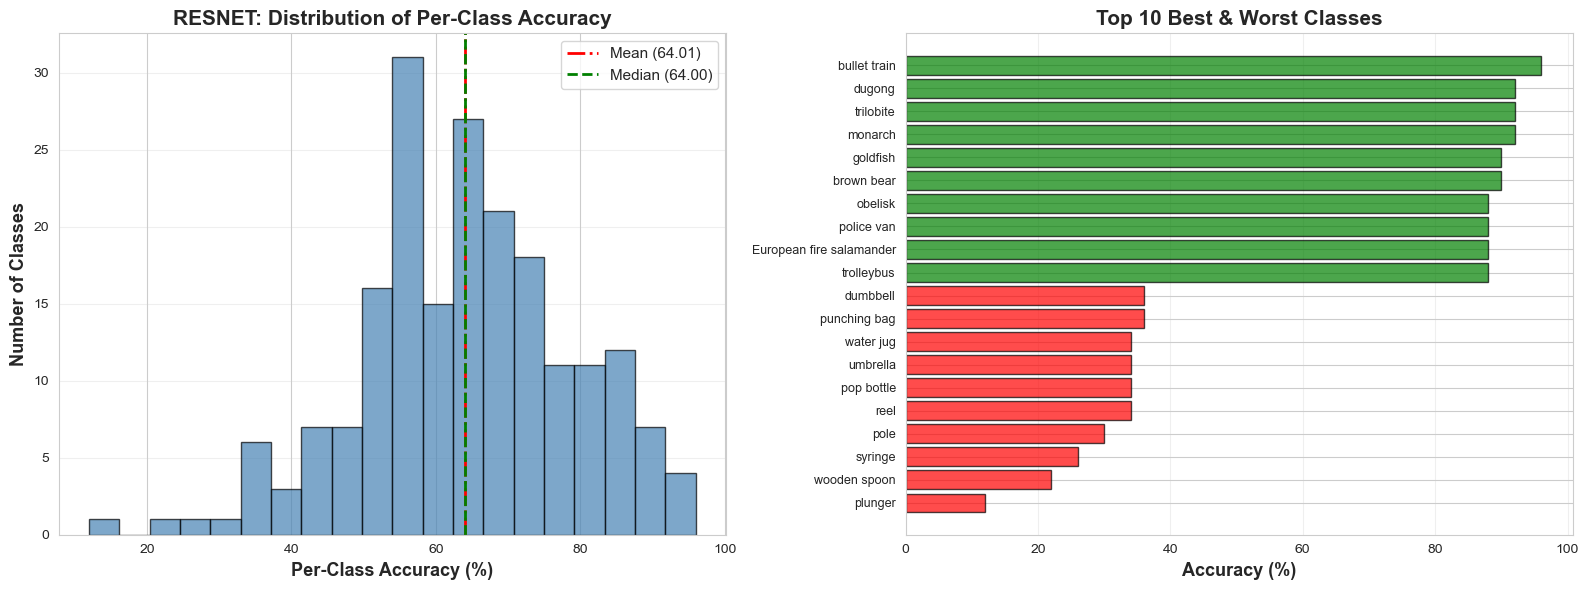

In [9]:
# Visualize per-class accuracy distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of accuracy distribution
axes[0].hist(class_acc_df['Accuracy (%)'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(class_acc_df['Accuracy (%)'].mean(), color='red', linestyle='-.', linewidth=2, label=f"Mean ({class_acc_df['Accuracy (%)'].mean():.2f})")
axes[0].axvline(class_acc_df['Accuracy (%)'].median(), color='green', linestyle='--', linewidth=2, label=f"Median ({class_acc_df['Accuracy (%)'].median():.2f})")
axes[0].set_xlabel('Per-Class Accuracy (%)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Number of Classes', fontsize=13, fontweight='bold')
axes[0].set_title(f'{model_name.upper()}: Distribution of Per-Class Accuracy', fontsize=15, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

# Bar chart of top 15 best and worst classes
top_bottom = pd.concat([class_acc_df.head(10), class_acc_df.tail(10)])
colors = ['green' if acc >= class_acc_df['Accuracy (%)'].mean() else 'red' 
          for acc in top_bottom['Accuracy (%)']]

y_pos = np.arange(len(top_bottom))
axes[1].barh(y_pos, top_bottom['Accuracy (%)'], color=colors, edgecolor='black', alpha=0.7)
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels([name[:30] for name in top_bottom['Class Name']], fontsize=9)
axes[1].set_xlabel('Accuracy (%)', fontsize=13, fontweight='bold')
axes[1].set_title('Top 10 Best & Worst Classes', fontsize=15, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

> The results indicate that the ResNet model attains a mean and median per-class accuracy of roughly 64% on Tiny ImageNet despite the highly constrained 64×64 input resolution, which inherently limits the model’s ability to capture fine-grained spatial detail. While the accuracy distribution is approximately symmetric, the very wide spread (from below 20% to above 90%) suggests that reduced resolution disproportionately affects classes requiring recognition of small, subtle, or texture-dependent features. Consistently high-performing classes are those with large, distinctive global shapes, whereas the worst-performing classes are small household objects or visually ambiguous items that are especially susceptible to information loss at 64×64. This pattern highlights that the dominant performance bottleneck is likely the low input resolution rather than the model architecture itself.

## 2. Confusion Matrix and Common Misclassifications

Normalized confusion matrix showing prediction patterns across all classes, plus a table of the most common misclassification pairs revealing systematic errors.

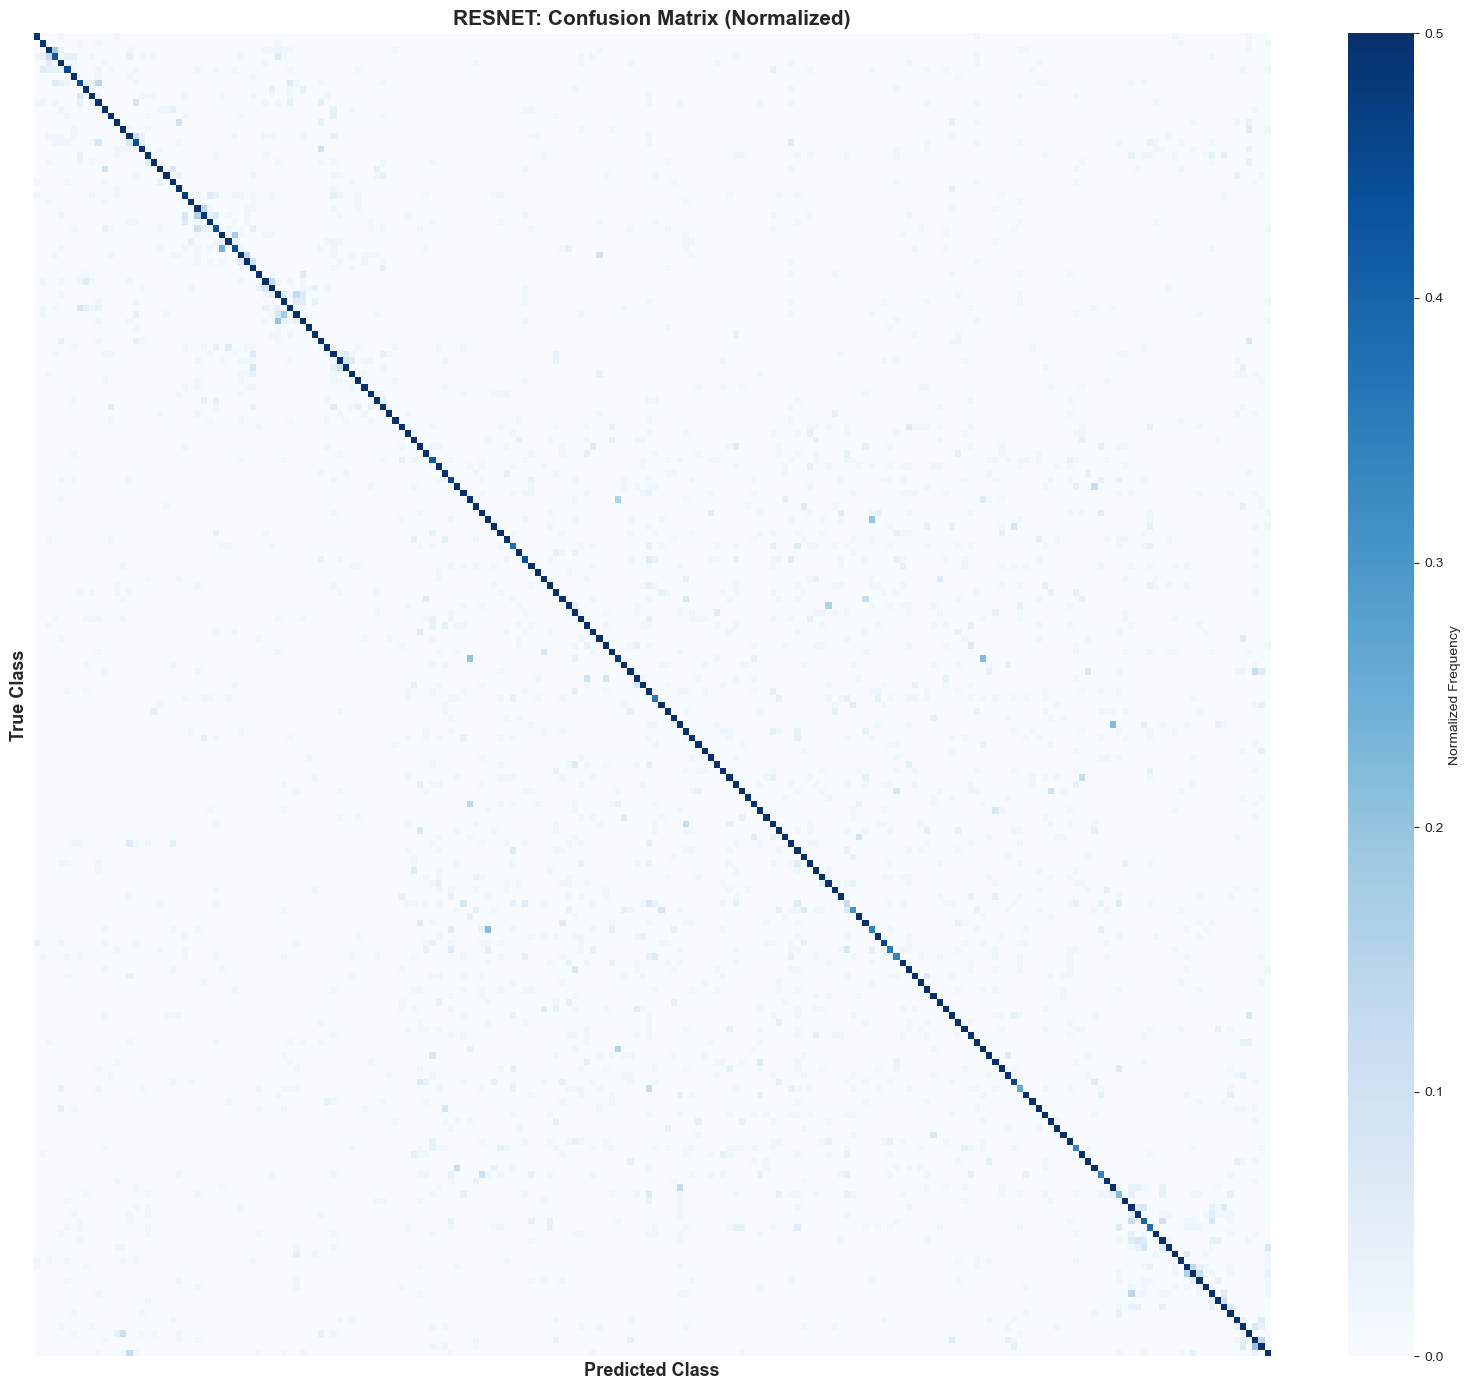

In [10]:
# Visualize confusion matrix (normalized)
cm = confusion_matrix(all_labels, all_preds)

# Normalize confusion matrix by row (true labels)
cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-10)

# Plot simplified confusion matrix (aggregate view)
plt.figure(figsize=(16, 14))
sns.heatmap(cm_normalized, cmap='Blues', vmin=0, vmax=0.5, 
            cbar_kws={'label': 'Normalized Frequency'},
            xticklabels=False, yticklabels=False)
plt.xlabel('Predicted Class', fontsize=13, fontweight='bold')
plt.ylabel('True Class', fontsize=13, fontweight='bold')
plt.title(f'{model_name.upper()}: Confusion Matrix (Normalized)', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

In [11]:
# Find most common misclassifications
misclassifications = []

for true_label in range(len(class_names)):
    for pred_label in range(len(class_names)):
        if true_label != pred_label and cm[true_label, pred_label] > 0:
            misclassifications.append({
                'True Class': class_names[true_label],
                'Predicted As': class_names[pred_label],
                'Count': int(cm[true_label, pred_label]),
            })

misclass_df = pd.DataFrame(misclassifications)
misclass_df = misclass_df.sort_values('Count', ascending=False)

print("="*80)
print("TOP 20 MOST COMMON MISCLASSIFICATIONS")
print("="*80)
print(misclass_df.head(20).to_string(index=False))
print("\n" + "="*80)

TOP 20 MOST COMMON MISCLASSIFICATIONS
        True Class       Predicted As  Count
      Egyptian cat              tabby     12
        frying pan                wok     11
       convertible         sports car     11
        pop bottle        beer bottle     11
       convertible        beach wagon     10
          seashore           lakeside     10
       beer bottle         pop bottle     10
         dragonfly        grasshopper     10
            mantis      walking stick      9
             tabby       Egyptian cat      9
          bullfrog        tailed frog      9
Labrador retriever   golden retriever      8
        sports car        convertible      8
      cash machine          pay-phone      8
             lemon             orange      8
       beach wagon        convertible      8
            orange              lemon      7
  golden retriever Labrador retriever      7
          lakeside           seashore      7
         meat loaf              plate      7



> The confusion matrix demonstrates that the RESNET model achieves strong classification performance, with predictions concentrated along the diagonal and misclassifications occurring infrequently and primarily between semantically or visually similar categories. The most frequent errors represent closely related animal species (e.g., Egyptian cat vs. tabby), similar object types (e.g., frying pan vs. wok), and related scene classes (e.g., seashore vs. lakeside), which indicates that residual mistakes arise from fine-grained distinctions rather than systematic failures. Overall, the results reflect a robust model whose remaining confusions are consistent with known challenges in ImageNet-scale fine-grained classification tasks.


## 3. Confidence Analysis and Model Calibration

Confidence distributions for correct vs. incorrect predictions, and calibration plot showing whether predicted confidence matches actual accuracy.

In [12]:
# Analyze prediction confidence
max_probs = np.max(all_probs, axis=1)
correct_mask = (all_preds == all_labels)

correct_confidences = max_probs[correct_mask]
incorrect_confidences = max_probs[~correct_mask]

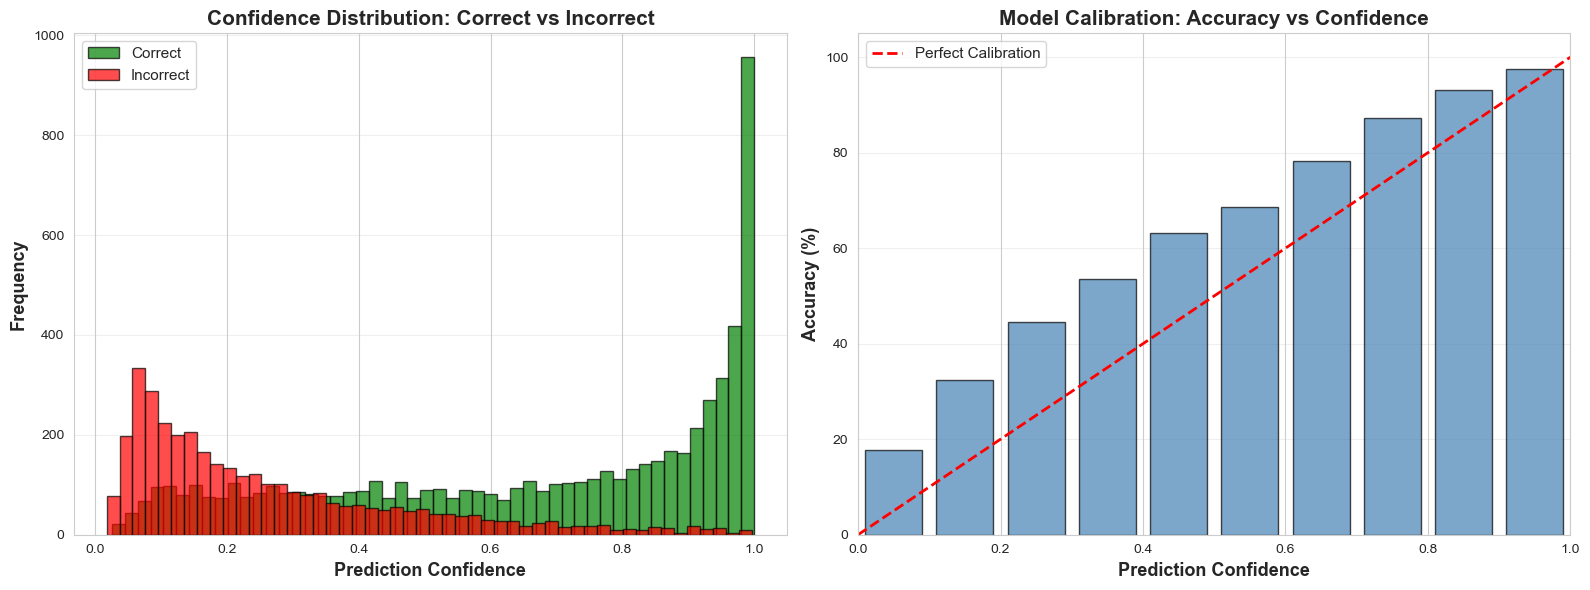

In [14]:
# Visualize confidence distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confidence distribution for correct vs incorrect
axes[0].hist(correct_confidences, bins=50, alpha=0.7, label='Correct', color='green', edgecolor='black')
axes[0].hist(incorrect_confidences, bins=50, alpha=0.7, label='Incorrect', color='red', edgecolor='black')
axes[0].set_xlabel('Prediction Confidence', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=13, fontweight='bold')
axes[0].set_title('Confidence Distribution: Correct vs Incorrect', fontsize=15, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

# Accuracy vs confidence bins
confidence_bins = np.linspace(0, 1, 11)
bin_centers = (confidence_bins[:-1] + confidence_bins[1:]) / 2
bin_accuracies = []

for i in range(len(confidence_bins) - 1):
    mask = (max_probs >= confidence_bins[i]) & (max_probs < confidence_bins[i+1])
    if mask.sum() > 0:
        bin_acc = (all_preds[mask] == all_labels[mask]).mean() * 100
        bin_accuracies.append(bin_acc)
    else:
        bin_accuracies.append(0)

axes[1].bar(bin_centers, bin_accuracies, width=0.08, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].plot([0, 1], [0, 100], 'r--', linewidth=2, label='Perfect Calibration')
axes[1].set_xlabel('Prediction Confidence', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
axes[1].set_title('Model Calibration: Accuracy vs Confidence', fontsize=15, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 105)

plt.tight_layout()
plt.show()

> The results indicate that the model is generally well-calibrated: correct predictions cluster strongly at high confidence levels, while incorrect predictions occur predominantly at low confidence, demonstrating that the model’s confidence estimates meaningfully reflect prediction reliability. The calibration curve further shows that empirical accuracy closely follows the ideal calibration line across confidence bins, with only minor deviations (slight overconfidence at low confidence levels and slight underconfidence at mid to high levels) suggesting that while the model’s probabilistic outputs are largely trustworthy, modest calibration refinement could further improve alignment in applications requiring high reliability.
